# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../../') 

# Import custom modules
from utils.data_cleaning import *
from utils.data_extraction import *
from utils.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [22]:
raw_data = load_data('../../data/france')
# Load data
companies = raw_data['companies']
investors = raw_data['investors']
investments = raw_data['investments']
funding_rounds = raw_data['funding_rounds']

print(f"Companies: {len(companies):,}")
print(f"Investors: {len(investors):,}")
print(f"Investments: {len(investments):,}")
print(f"Funding rounds: {len(funding_rounds):,}")

Companies: 56,797
Investors: 4,564
Investments: 23,420
Funding rounds: 14,375


In [23]:
# Data cleaning based on Dalle et al. + Carniel insights
cleaned_data = create_final_sample(raw_data, funding_threshold=150000)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")


1. Cleaning companies data
Initial companies count: 56797
Removed 9151 companies founded after 2017
Removed 4231 companies with exit status
Final companies count after cleaning: 43415
Total removed: 13382

2. Cleaning funding data
Initial investments count: 23420
Removed 2533 investments with invalid funding amounts
Final investments count after cleaning: 20887
Total removed: 2533

3. Apply funding threshold ($150,000 as per paper)
Applying funding threshold of $150,000
Companies meeting funding threshold: 4854
Filtered companies: 2415
Filtered investments: 20650

4. Excluding accelerator-only companies (prevent endogeneity bias)
Companies with accelerator-only funding: 116
Companies after excluding accelerator-only: 2361
Investments after excluding accelerator-only: 20505

FINAL SAMPLE:
Companies: 2361
Investments: 10163
Unique investors: 2343
After cleaning:
Companies: 2,361
Investors: 4,564


## Accelerator-VC Network Construction

In [24]:
accelerated_investments = extract_accelerator_investments(cleaned_data['investments'])

print("\nSample of accelerator investments:")
if 'company_name' in accelerated_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(accelerated_investments[display_cols].head())
else:
    print(accelerated_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
print("\nAccelerator-VC pairs:")
accelerator_vc_investments_pairs = create_investment_pairs(accelerated_investments, vc_investments, 'acc', 'vc')
print(accelerator_vc_investments_pairs[['org_uuid', 'investor_name_acc', 'investor_name_vc']].head())

Found 675 accelerator investments
Unique companies in accelerators: 483

Sample of accelerator investments:
        company_name    investor_name investor_types  total_funding_usd
342   La Cartoonerie            WILCO    accelerator           676000.0
444          Force-A            WILCO    accelerator          7488077.0
631         Geodruid            WILCO    accelerator           177526.0
985          Homeloc        Netangels    accelerator           131845.0
1251        Mobypark  Startupbootcamp    accelerator           837000.0
Found 5705 VC investments
Unique companies with VC funding: 1835

Sample of VC investments:
            company_name      investor_name  \
1                 TVtrip  Balderton Capital   
2                 TVtrip            Partech   
9                 Twenga           3i Group   
29                 MyFab              Alven   
38  Inspirational Stores      Atlas Venture   

                         investor_types  total_funding_usd  
1                       

## Static Ecological Network Analysis

Analysis using ecological metrics inspired by Carniel's framework.

In [25]:
acc_vc_edges = extract_bipartite_edges_from_pairs(
    accelerator_vc_investments_pairs, 
    'investor_name_acc', 
    'investor_name_vc',
    'total_funding_usd'
)

# Bbipartite analysis with ecological metrics
network_analysis = analyze_bipartite_structure_robust(
    acc_vc_edges,
    'investor_name_acc',
    'investor_name_vc',
    'total_funding_usd',
    'Accelerators',
    'VCs',
    handle_overlap='suffix'
)

# Extract key metrics
basic_metrics = network_analysis['basic_metrics']
ecological_summary = network_analysis['ecological_summary']

print("=== Network Structure ===")
print(f"Nodes: {basic_metrics['num_nodes']} ({basic_metrics['set_0_size']} accelerators + {basic_metrics['set_1_size']} VCs)")
print(f"Edges: {basic_metrics['num_edges']}")
print(f"Density: {basic_metrics['density']:.3f}")
print(f"Components: {basic_metrics['num_components']}")

print("\n=== Ecological Metrics ===")
print(f"Connectance: {ecological_summary['connectance']:.3f}") # Or density
print(f"Nestedness (NODF): {ecological_summary['nestedness_nodf']:.1f}")
print(f"Modularity: {ecological_summary['modularity']:.3f}")

# @todo review cross assortativity, maybe doenst make sense
# print(f"Cross-assortativity: {ecological_summary['cross_assortativity']:.3f}")

Overlapping nodes: ['Raise Ventures']
Added suffixes to create pseudo-bipartite structure
=== Network Structure ===
Nodes: 744 (117 accelerators + 627 VCs)
Edges: 1352
Density: 0.018
Components: 12

=== Ecological Metrics ===
Connectance: 0.018
Nestedness (NODF): 11.0
Modularity: 0.302


In [26]:
# Ecological interpretation
ecology_summary = summarize_bipartite_ecology(network_analysis)

print("=== Ecological Interpretation ===")
print(f"Network Type: {ecology_summary['network_type']}")
print(f"Connectance: {ecology_summary['connectance_interpretation']}")
print(f"Nestedness: {ecology_summary['nestedness_interpretation']}")
print(f"Modularity: {ecology_summary['modularity_interpretation']}")
print(f"Resilience: {ecology_summary['resilience_prediction']}")

=== Ecological Interpretation ===
Network Type: Modular (compartmentalized)
Connectance: Low connectance - sparse network
Nestedness: Low nestedness - modular structure
Modularity: High modularity - strong community structure
Resilience: Variable resilience patterns


#### Comments

Putting aside all the work that should be done to formaliza and "prove" statistically wheter such values are high, or low, I'll try to interpretate them through the lens of Network Theory, in special Social Network Theory. As we are talking about a bipartite network, ecology and mutualistic (polnazator-plants) theory will also be considered.
 
Starting by nesteness. For the french network, we've got a low (is it statistically true?) value. It means multiple things, I try to summarize some of them in the following list (not exhaustive, I am still searching for bilbiography):

- There isn't a so called "herarchical" or "mutualistic" structure, where less connected "polinizators" tend to interact with a subset of the "plants" polinized by more connected "polinizators". Slightly different interpretations (but  with similar practical consequences) ca
n be taken by considering either accelarators = polinizator and vc = plant or, the opposite, vc = polinizator and accelarator = plant.

- In any case, nestedness is also related to the vunerability of the ecosystem we're studing. It's hard to affirm categorically that a network is more vunerable or less vunerable by looking to nestedness, but we can characterize this vunerability. In one hand, higher nestedness is associated with economic resilience to external crisis in economic complexity theory (Theo has good references on that regard), but it also means that the "distribution" of how much each actor (either accelarator or vc) contributes to the overall resilience (or vunerability) is concentrated in a restricted (and probably small) group of agents. So if a strongly connected agent, which would be probably more resilient and predictable (need to prove it...), faces bankrupcy, for sure a more hierarchised (higher nestedness) will sufer more.

- From a more ecological perspective, higher nestedness tends to be associated with fewer competitaion between species, which lead to more biodiveristy, increasing "structural stability". However, disturbs on generalists tends to result on accelerated species exhaustion / depletion, as specialists become isolated (consequence of nestedness structure). So if the French acc-vc ecosystem has possibily low nestedness, the opposite line of reasoning must be applied.

Now if we look to connectance (measure the density of links, aka, ratio of number of existing links and all possible links) and modularity (indicates how sparse a matrix is, normally associated with the formation of clusters or community structures), most probably we'll be able to indentify clusters, as high modularity is associated with sparse matrix and low connectance may facilitate the visualization and interpretation of such clusters (to be obtained with non-supervised learning....)

## Time Series Ecological Network Analysis

In [61]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
acc_vc_inv_pairs_ts = accelerator_vc_investments_pairs.copy()

# Convert to datetime and extract year
# acc_vc_inv_pairs_ts['announced_year'] = pd.to_datetime(acc_vc_inv_pairs_ts['announced_year'])
acc_vc_inv_pairs_ts['year'] = acc_vc_inv_pairs_ts['announced_year']

# Get the range of years
min_year = 2011
max_year = 2023

# Filter out rows with missing dates
acc_vc_inv_pairs_ts = acc_vc_inv_pairs_ts.dropna(subset=['year'])
acc_vc_inv_pairs_ts = acc_vc_inv_pairs_ts[(acc_vc_inv_pairs_ts['year'] >= min_year) & (acc_vc_inv_pairs_ts['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(acc_vc_inv_pairs_ts):,}")

# Show distribution by year
year_counts = acc_vc_inv_pairs_ts['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2011 to 2023
Total investments with dates: 2,673

Investments per year:
year
2011     23
2012     33
2013     38
2014    109
2015    168
2016    223
2017    319
2018    292
2019    394
2020    219
2021    310
2022    337
2023    208
Name: count, dtype: int64


### Snapshot-based analysis

In [62]:
# Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
# @todo fix min e max year
for year in range(min_year, max_year + 1):
    cur_year_acc_vc_inv_pairs = acc_vc_inv_pairs_ts[acc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_acc_vc_inv_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_acc_vc_inv_pairs)} investments)")
        continue
    
    try:
        # Extract bipartite edges for this year
        year_edges = extract_bipartite_edges_from_pairs(
            cur_year_acc_vc_inv_pairs,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd'
        )
        
        if len(year_edges) < min_edges_threshold:
            print(f"Year {year}: Skipping (only {len(year_edges)} edges after processing)")
            continue
        
        # Analyze bipartite structure for this year
        year_analysis = analyze_bipartite_structure_robust(
            year_edges,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd',
            'Accelerators',
            'VCs',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        basic_metrics = year_analysis['basic_metrics']
        ecological_summary = year_analysis['ecological_summary']
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': basic_metrics['num_nodes'],
            'num_accelerators': basic_metrics['set_0_size'],
            'num_vcs': basic_metrics['set_1_size'],
            'num_edges': basic_metrics['num_edges'],
            'density': basic_metrics['density'],
            'connectance': ecological_summary['connectance'],
            'nestedness_nodf': ecological_summary['nestedness_nodf'],
            'modularity': ecological_summary['modularity'],
            'cross_assortativity': ecological_summary['cross_assortativity'],
            'num_components': basic_metrics['num_components']
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {basic_metrics['num_nodes']} nodes, {basic_metrics['num_edges']} edges, "
              f"Connectance: {ecological_summary['connectance']:.3f}, "
              f"Nestedness: {ecological_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {ecological_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years")

Computing ecological metrics for each year...
Year 2011: 27 nodes, 18 edges, Connectance: 0.102, Nestedness: 0.0, Modularity: 0.461
Year 2012: 32 nodes, 25 edges, Connectance: 0.121, Nestedness: 19.9, Modularity: 0.409
Year 2013: 43 nodes, 32 edges, Connectance: 0.070, Nestedness: 5.9, Modularity: 0.437
Year 2014: 70 nodes, 77 edges, Connectance: 0.079, Nestedness: 10.3, Modularity: 0.386
Year 2015: 106 nodes, 120 edges, Connectance: 0.051, Nestedness: 15.3, Modularity: 0.394
Year 2016: 125 nodes, 166 edges, Connectance: 0.055, Nestedness: 15.9, Modularity: 0.355
Year 2017: 139 nodes, 207 edges, Connectance: 0.051, Nestedness: 18.3, Modularity: 0.311
Year 2018: 171 nodes, 225 edges, Connectance: 0.039, Nestedness: 15.5, Modularity: 0.349
Year 2019: 205 nodes, 294 edges, Connectance: 0.038, Nestedness: 12.2, Modularity: 0.356
Year 2020: 161 nodes, 190 edges, Connectance: 0.039, Nestedness: 13.8, Modularity: 0.395
Year 2021: 197 nodes, 239 edges, Connectance: 0.033, Nestedness: 12.2, Mod

In [63]:
# Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_accelerators  num_vcs  num_edges  density  \
count    13.000     13.000            13.000   13.000     13.000   13.000   
mean   2017.000    126.538            33.615   92.923    156.231    0.058   
std       3.894     65.377            14.373   51.432     93.385    0.028   
min    2011.000     27.000             9.000   16.000     18.000    0.033   
25%    2014.000     70.000            20.000   51.000     77.000    0.038   
50%    2017.000    139.000            39.000   97.000    180.000    0.051   
75%    2020.000    171.000            46.000  127.000    225.000    0.070   
max    2023.000    205.000            49.000  156.000    294.000    0.121   

       connectance  nestedness_nodf  modularity  cross_assortativity  \
count       13.000           13.000      13.000               13.000   
mean         0.058           12.118       0.390               -0.042   
std          0.028            5.385       0.040              

Evolution of ecological metrics over time in the French accelerator-VC ecosystem.

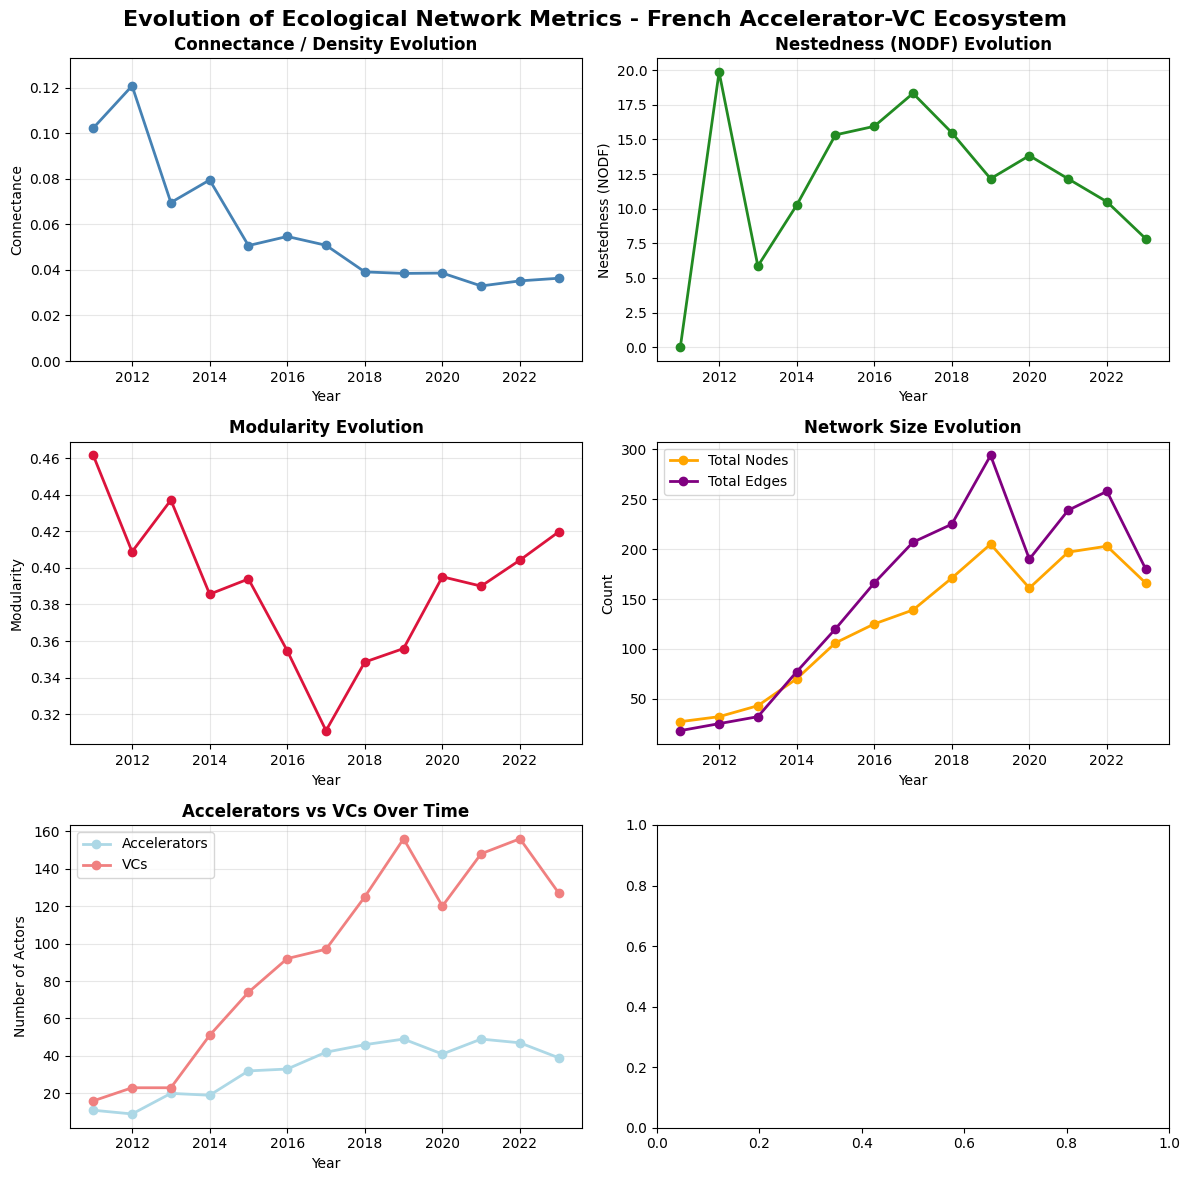

In [71]:
if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    fig.suptitle('Evolution of Ecological Network Metrics - French Accelerator-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0, 0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0, 0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Connectance')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[0, 1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[0, 1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Nestedness (NODF)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[1, 0].plot(ts_df['year'], ts_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[1, 0].set_title('Modularity Evolution', fontweight='bold')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Modularity')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[1, 1].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[1, 1].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[1, 1].set_title('Network Size Evolution', fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[2, 0].plot(ts_df['year'], ts_df['num_accelerators'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[2, 0].plot(ts_df['year'], ts_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[2, 0].set_title('Accelerators vs VCs Over Time', fontweight='bold')
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Number of Actors')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

#### Comments

The time series analysis reveals how the French accelerator-VC ecosystem has evolved over time. Key insights to consider:

- **Connectance trends**: Changes in network density may indicate ecosystem maturation or market concentration
- **Nestedness evolution**: Temporal changes in hierarchical structure reflect ecosystem organization and potential vulnerability patterns
- **Modularity dynamics**: Evolution of community structure indicates specialization and clustering patterns
- **Growth patterns**: The relationship between network size and structural metrics reveals ecosystem scaling properties. Event scaling

These temporal patterns can be compared with economic cycles, policy changes, and market events to understand ecosystem resilience and adaptation mechanisms.

...Nestedness and modularity over year seems to follow inverse proportion

Before 2017 -> lower modularity and higher nestedness trends
After 20217 -> higher modularity and lower nestedess trends

- Why has it changed so much ?

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0055 per year (total: -0.0659)
nestedness_nodf: +0.6529 per year (total: +7.8344)
modularity: -0.0035 per year (total: -0.0418)
num_nodes: +11.5833 per year (total: +139.0000)
num_edges: +13.5000 per year (total: +162.0000)

Correlations between metrics and time:
connectance: r=-0.869 (decreasing trend)
nestedness_nodf: r=0.117 (increasing trend)
modularity: r=-0.276 (decreasing trend)


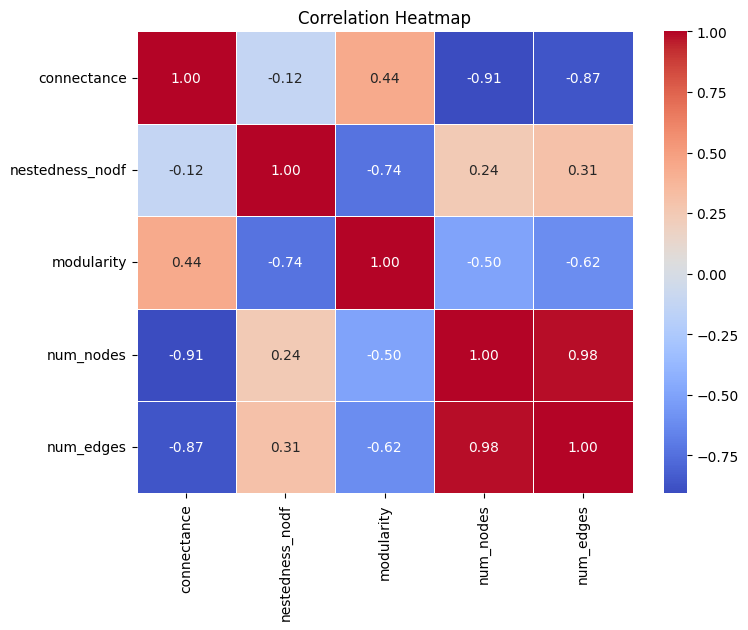

In [69]:
if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_df.columns:
            correlation = ts_df['year'].corr(ts_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

#### Comments

Following literature interpretation:

**High modularity and low nestedness** → strongly compartmentalized networks, but without internal hierarchy.
Example: ecosystems with isolated guilds, almost no species overlap.

**Low modularity and high nestedness** → non-compartmentalized networks, but with a clear hierarchy of connections.
Example: mutualistic plant-pollinator networks in tropical ecosystems.

**High modularity and high nestedness** → rare, but possible if each module is internally nested (hierarchical structures within compartments).

**Low modularity and low nestedness** → more random networks, with no evident pattern.

### Cumulative network analysis (5 years window)

In [ ]:
...

## Export results

In [67]:
# Save time series results for further analysis
if len(ts_df) > 0:
    # Create comprehensive time series report
    time_series_report = {
        'dataset': 'French Startup Ecosystem - Time Series',
        'analysis_date': '2025-07-26',
        'time_period': {
            'start_year': int(ts_df['year'].min()),
            'end_year': int(ts_df['year'].max()),
            'num_years_analyzed': len(ts_df)
        },
        'annual_metrics': ts_df.to_dict('records'),
        'trends': {}
    }
    
    # Add trend calculations if enough data
    if len(ts_df) > 1:
        for metric in ['connectance', 'nestedness_nodf', 'modularity']:
            correlation = ts_df['year'].corr(ts_df[metric])
            time_series_report['trends'][metric] = {
                'correlation_with_time': correlation,
                'trend_direction': 'increasing' if correlation > 0.1 else 'decreasing' if correlation < -0.1 else 'stable'
            }
    
    # Save to file
    import json
    with open('french_network_timeseries_2025.json', 'w') as f:
        json.dump(time_series_report, f, indent=2, default=str)
    
    print(f"Time series analysis saved to 'french_network_timeseries_2025.json'")
    print(f"Analysis covers {len(ts_df)} years from {ts_df['year'].min()} to {ts_df['year'].max()}")
else:
    print("No time series data to save")

Time series analysis saved to 'french_network_timeseries_2025.json'
Analysis covers 13 years from 2011 to 2023


In [68]:
# Save report for future comparisons
""" import json
with open('network_report_2025.json', 'w') as f:
    json.dump(network_report, f, indent=2, default=str)

print("Network report saved to 'network_report_2025.json'")
print("Ready for comparative analysis with other datasets.") """

' import json\nwith open(\'network_report_2025.json\', \'w\') as f:\n    json.dump(network_report, f, indent=2, default=str)\n\nprint("Network report saved to \'network_report_2025.json\'")\nprint("Ready for comparative analysis with other datasets.") '